In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
import glob
import pickle
import matplotlib.pyplot as plt
import numpy as np
import colorcet as cc
from importlib import reload
from scipy.optimize import curve_fit



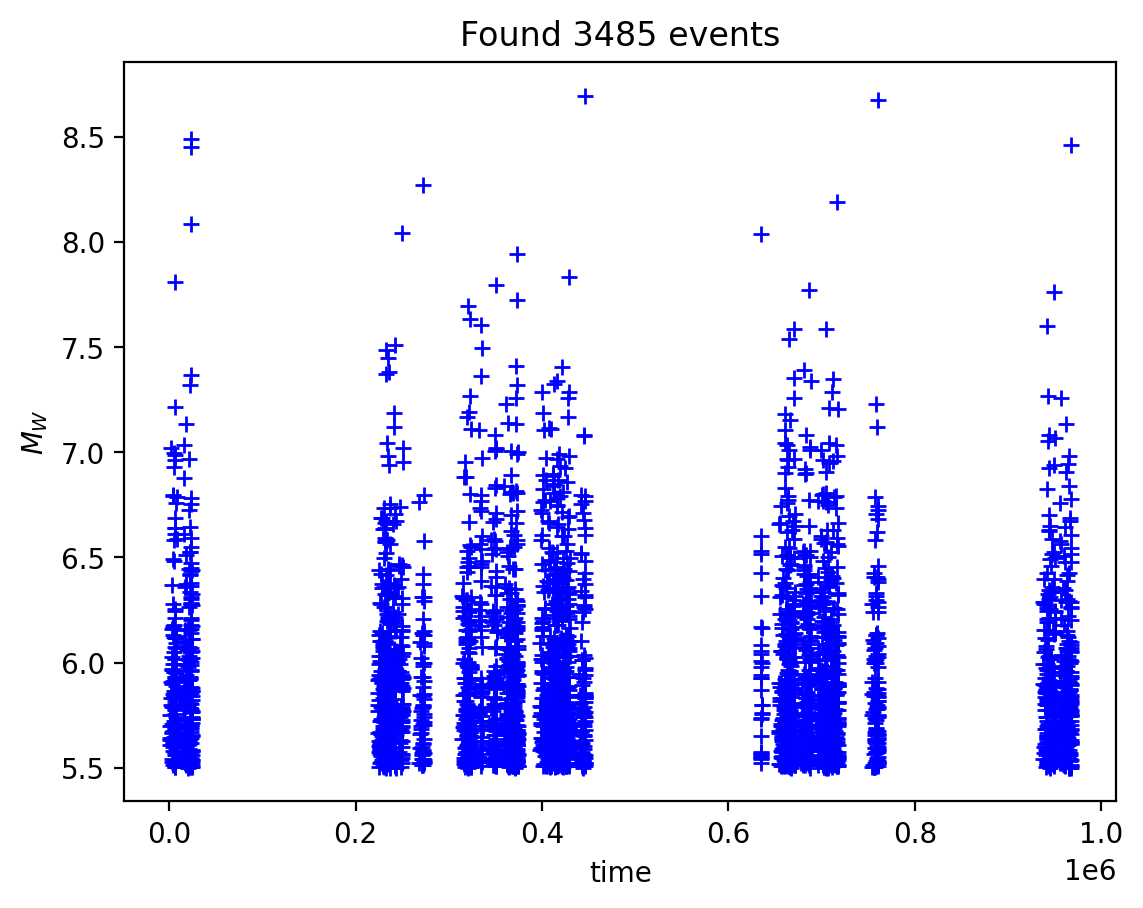

In [3]:
def get_most_recent_output_folder_name():
    most_recent_output_folder_name = sorted(glob.glob("./runs/*"))[-1]
    return most_recent_output_folder_name


most_recent_output_folder_name = get_most_recent_output_folder_name()
time_series = pickle.load(
    open(most_recent_output_folder_name + "/time_series.pickle", "rb")
)

index = np.where(time_series.event_magnitude > 0.0)[0]
plt.plot(time_series.time[index], time_series.event_magnitude[index], "b+")
plt.xlabel("time")
plt.ylabel("$M_W$")
plt.title(f"Found {index.size} events")
plt.show()


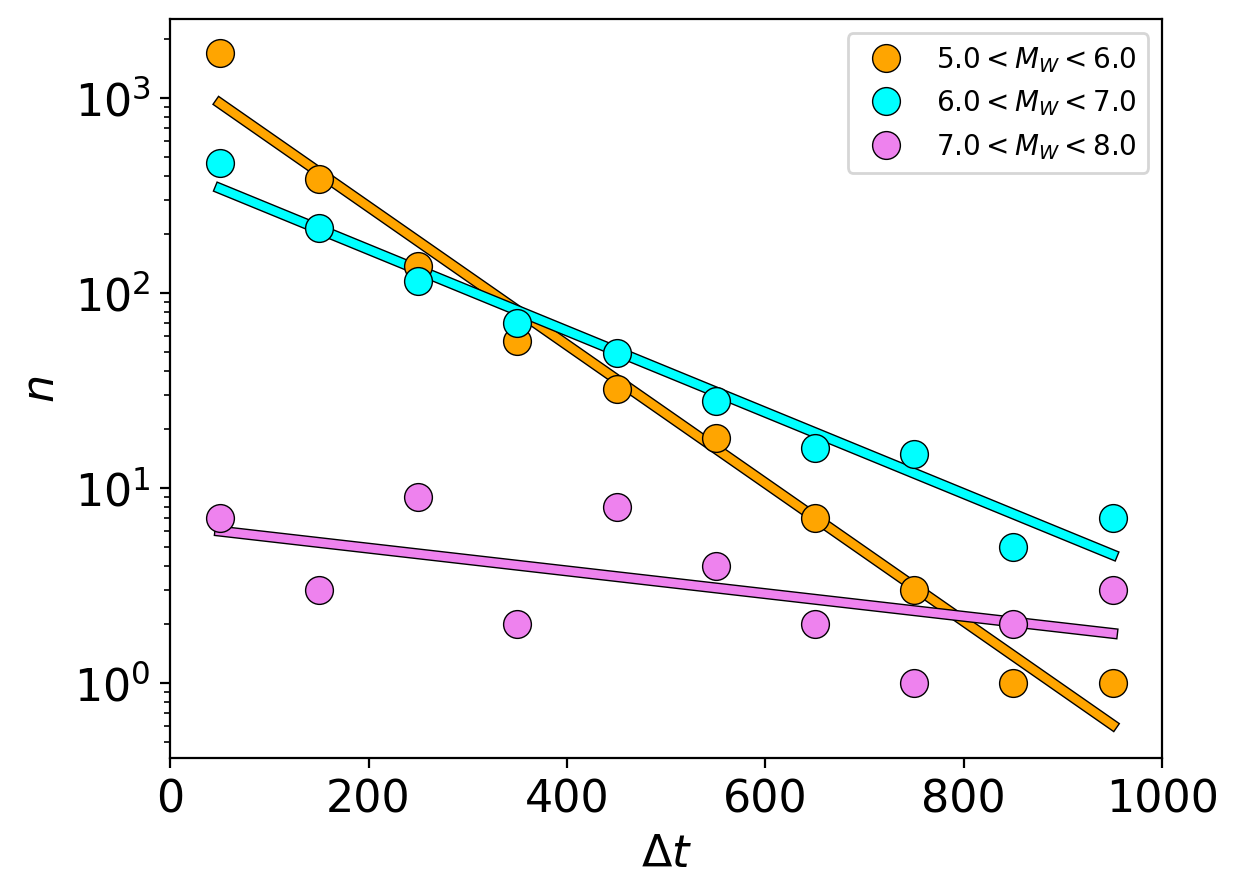

In [13]:
def fit_function(x, a, b):
    return a * x + b


delta_t_bins = np.linspace(0, 1000, 11)
delta_t_bin_centers = (np.diff(delta_t_bins) + delta_t_bins[0:-1]) - 0.5 * (
    delta_t_bins[1] - delta_t_bins[0]
)

counts_all, _ = np.histogram(
    np.diff(time_series.time[np.where(time_series.event_magnitude > 0.0)[0]]),
    bins=delta_t_bins,
)

magnitude_bins = np.array([5.0, 6.0, 7.0, 8.0])
counts = list()
models = list()
for i in range(len(magnitude_bins) - 1):
    lower_indices = np.where(time_series.event_magnitude >= magnitude_bins[i])
    upper_indices = np.where(time_series.event_magnitude < magnitude_bins[i + 1])
    a = np.intersect1d(lower_indices, upper_indices)
    counts_local, _ = np.histogram(np.diff(time_series.time[a]), bins=delta_t_bins)
    counts.append(counts_local)

    # Calculate best fit exponential
    popt, pcov = curve_fit(
        fit_function, delta_t_bin_centers, np.log(counts[i]), maxfev=5000
    )
    model = fit_function(delta_t_bin_centers, popt[0], popt[1])
    model = np.exp(model)
    models.append(model)


markersize = 10
alpha = 1.0
fontsize = 16

plt.figure()

color_strings = ["orange", "cyan", "violet"]
for i in range(len(magnitude_bins) - 1):
    label_string = f"{magnitude_bins[i]}" + "$ < M_W < $" + f"{magnitude_bins[i + 1]}"
    plt.semilogy(
        delta_t_bin_centers,
        models[i],
        "-",
        linewidth=4,
        color="k",
        alpha=alpha,
        zorder=10,
    )
    plt.semilogy(
        delta_t_bin_centers,
        models[i],
        "--",
        linewidth=3,
        color=color_strings[i],
        alpha=alpha,
        zorder=10,
    )

    plt.semilogy(
        delta_t_bin_centers,
        counts[i],
        "o",
        label=label_string,
        markeredgecolor="k",
        markeredgewidth=0.5,
        markersize=markersize,
        color=color_strings[i],
        alpha=alpha,
        zorder=20,
    )
plt.legend()
plt.xlim([0, np.max(delta_t_bins)])
plt.xlabel("$\Delta t$", fontsize=fontsize)
plt.ylabel("$n$", fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.show()


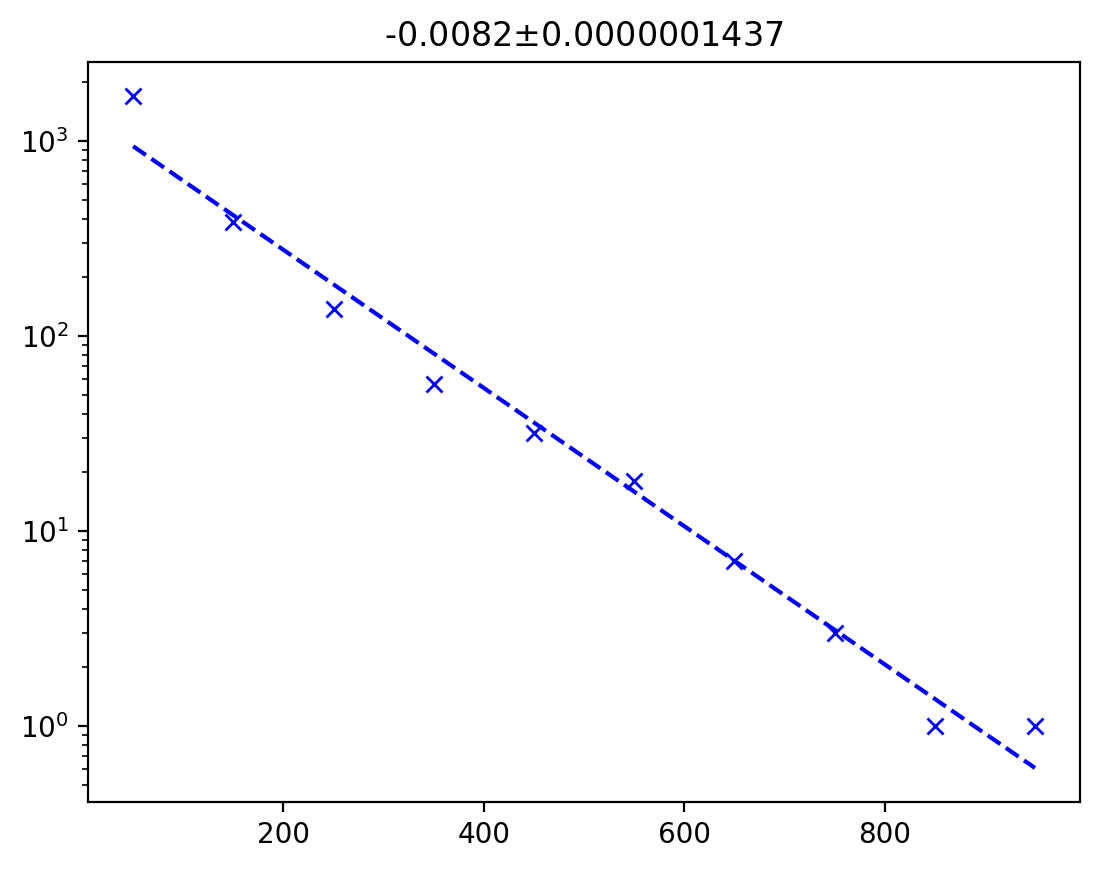

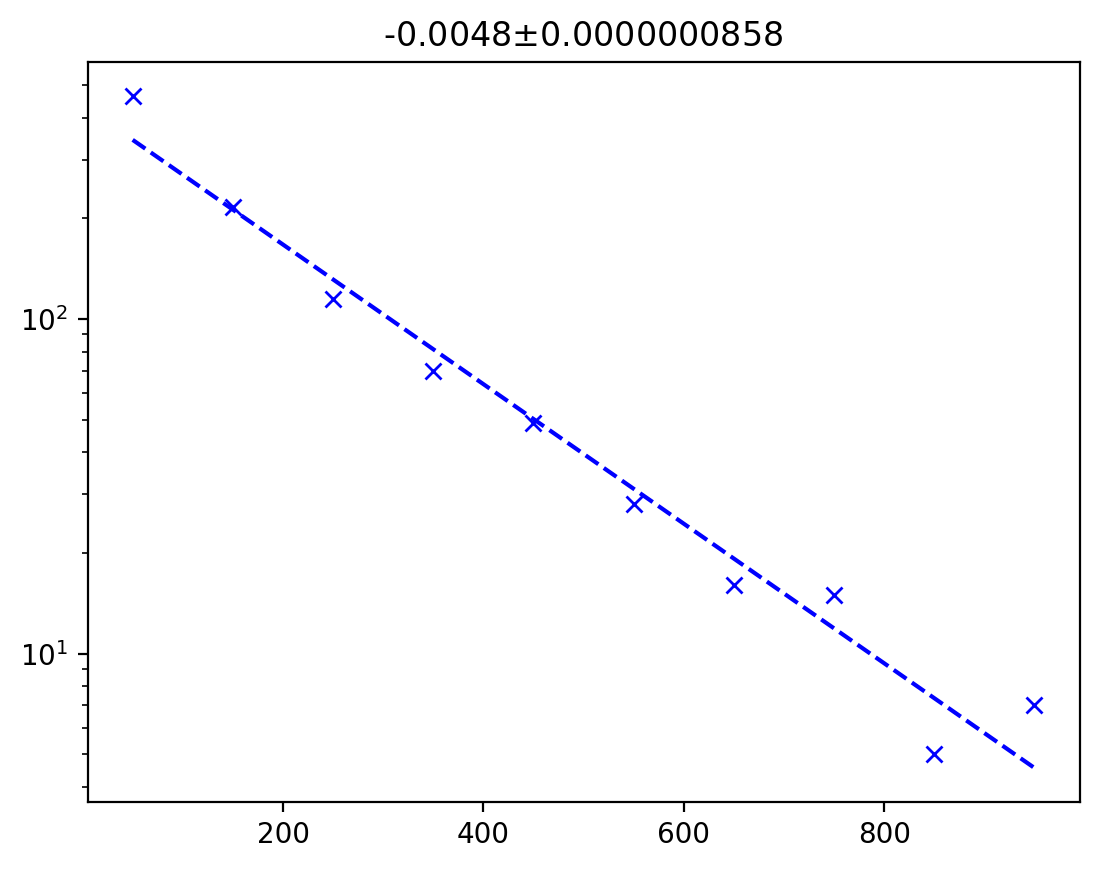

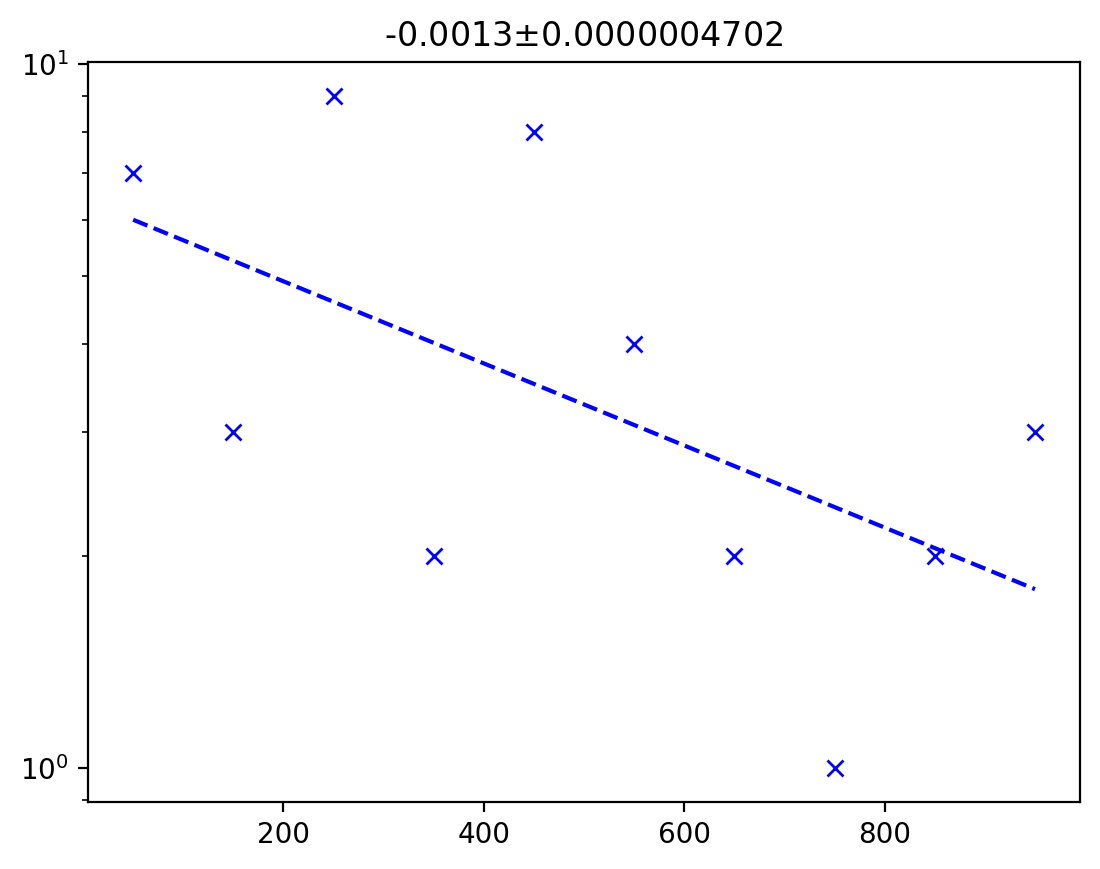

In [6]:



for i in range(3):
    popt, pcov = curve_fit(
        fit_function, delta_t_bin_centers, np.log(counts[i]), maxfev=5000
    )
    ymodel = fit_function(delta_t_bin_centers, popt[0], popt[1])
    ymodel = np.exp(ymodel)
    plt.semilogy(delta_t_bin_centers, counts[i], "bx")
    plt.semilogy(delta_t_bin_centers, ymodel, "--b")
    fit_string = f"{popt[0]:0.4f}" + "$\pm$" + f"{pcov[0,0]:0.10f}"
    plt.title(fit_string)
    plt.show()
